# Saving Data to External Files
This notebook gives examples of how to write out selected data from [`GBTFitsLoad`](https://dysh.readthedocs.io/en/latest/modules/dysh.fits.html#module-dysh.fits.gbtfitsload) and how to save 
[`Spectrum`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.spectrum), 
[`Scan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.scan), and 
[`ScanBlock`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) to different formats.

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/dataIO.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/dataIO.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for loading and reading data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.spectrum import Spectrum

# We will use matplotlib for plotting.
import matplotlib.pyplot as plt

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.642740
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


### Calibrate a position switched scan.  

This returns a `ScanBlock` containing one [`PSScan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.PSScan) with 11 integrations for the ON position and 11 integrations for the OFF position.

In [4]:
ps_scan_block = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

In [5]:
print(f"Number of integrations = {ps_scan_block[0].nrows}")

Number of integrations = 22


Get the time average of the calibrated data. This method returns a `Spectrum`.

In [6]:
ta = ps_scan_block.timeaverage()

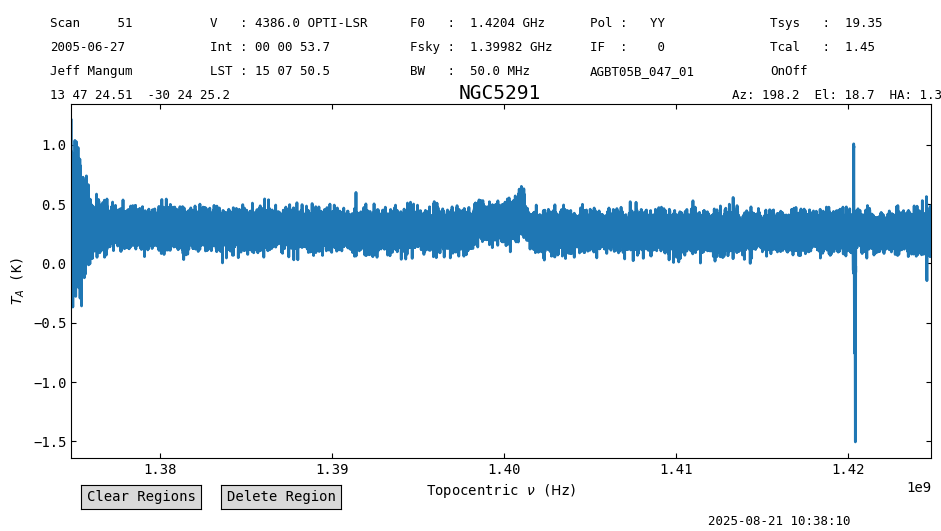

In [7]:
ta.plot()

## Reading and Writing Individual Spectra

###  Inputs and Outputs
`dysh` supports output to text files in a variety of [formats familiar to users of astropy](https://docs.astropy.org/en/stable/io/ascii/index.html#id1):
* basic
* commented_header
* ECSV
* fixed_width
* IPAC
* MRT
* votable

The following lines of code define some of the available formats in a list, and then loop over them saving the calibrated data in each format.
We use the `overwrite=True` parameter to avoid errors if the files already exist on disk.

In [8]:
# Define the formats in a list.
fmt = [ 
    "basic",
    "commented_header",
    "ecsv",
    "fixed_width",
    "ipac",
    "mrt",
    "votable",
]

# Define the output directory and create it if it does not exists already.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

# Loop over formats writing the calibrated spectrum.
for f in fmt:
    file = output_dir / f"testwrite.{f}"
    ta.write(file, format=f, overwrite=True)

We can also write a `Spectrum` to FITS format.

In [9]:
ta.write(output_dir / "testwrite.fits", format="fits", overwrite=True)

We can read spectra in FITS and a few formats. [As noted in astropy, ECSV ](https://docs.astropy.org/en/stable/io/ascii/ecsv.html#ecsv-format) is the only ASCII format that can make a lossless output-input roundtrip and thus reproduce an original spectrum.

We use the `Spectrum.read` method to read the saved data.

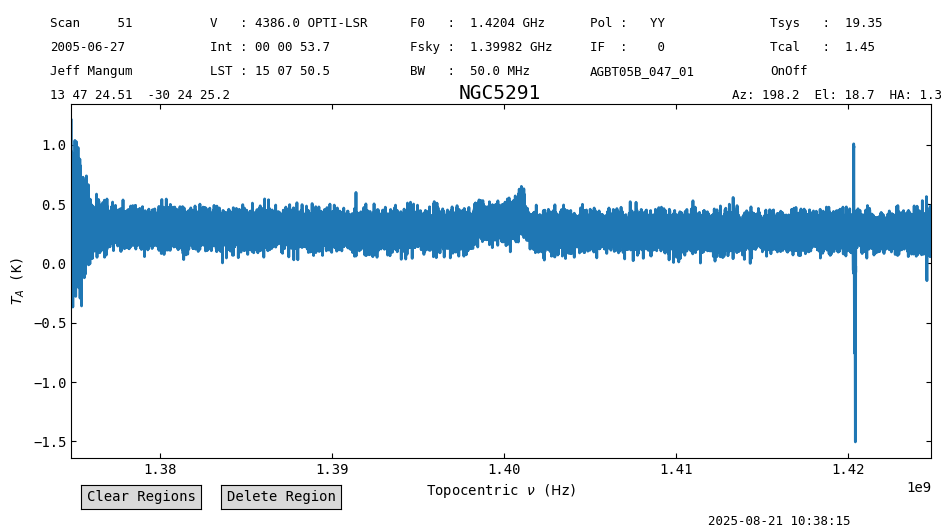

In [10]:
s1 = Spectrum.read(output_dir / "testwrite.fits", format="fits")
s1.plot()

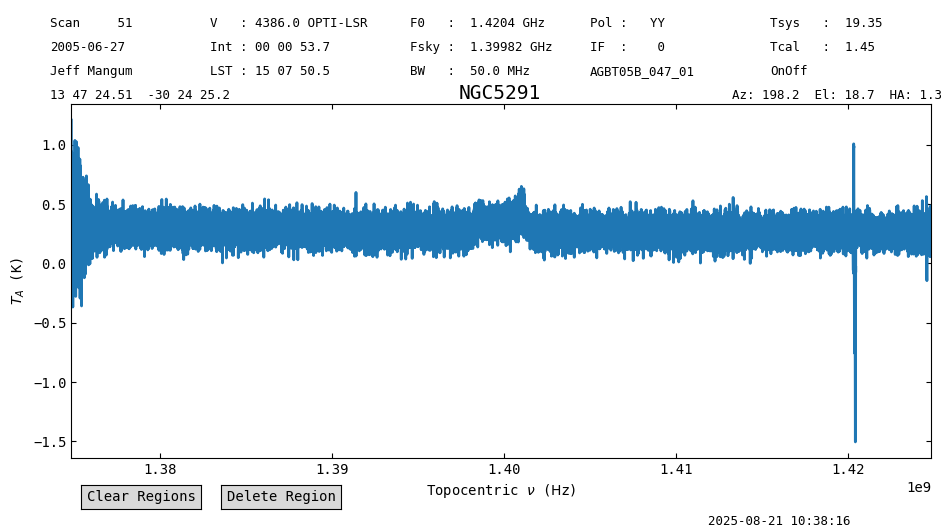

In [11]:
s2 = Spectrum.read(output_dir / "testwrite.ecsv", format="ecsv")
s2.plot()

### GBTIDL ASCII format
`dysh` can read text files created by GBTIDL's `write_ascii` function. However, those files do not provide sufficient metadata to fully recreate the spectrum.  (For instance, they do not have complete sky coordinate information.)  

In [12]:
url = "https://www.gb.nrao.edu/dysh/example_data/onoff-L/gbtidl-data/onoff-L_gettp_156_intnum_0_HEL.ascii"
filename_ascii = from_url(url, savepath)
s3 = Spectrum.read(filename_ascii, format='gbtidl')

In [13]:
print(s3, "\n", s3.meta)

Spectrum1D (length=32768)
Flux=[3608710. 3553598. 3604808. ... 3523171. 3545982. 3474847.] ct,  mean=493422767.43425 ct
Spectral Axis=[1.42009237 1.42009166 1.42009094 ... 1.39665654 1.39665582
               1.39665511] GHz,  mean=1.40837 GHz 
 {'SCAN': 156, 'OBJECT': 'NGC2782', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 119.42083333333332, 'VELDEF': 'None-HEL', 'POL': 'YY'}


`dysh` can even read compressed ASCII files. Note these data have velocity on the spectral axis.

In [14]:
url = "https://www.gb.nrao.edu/dysh/example_data/onoff-L/gbtidl-data/onoff-L_getps_152_RADI-HEL.ascii.gz"
filename_ascii_gz = from_url(url, savepath)
s4 = Spectrum.read(filename_ascii_gz, format='gbtidl')

In [15]:
print(s4, "\n", s4.meta)

Spectrum1D (length=32768)
Flux=[-0.1042543   0.05250004  0.00432693 ... -0.05038555  0.03408394
       0.06139921] K,  mean=0.17345 K
Spectral Axis=[1281.15245599 1281.30342637 1281.45439674 ... 6227.69690405
               6227.84787443 6227.99884481] km / s,  mean=3754.57565 km / s 
 {'SCAN': 152, 'OBJECT': 'NGC2415', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 114.65624999999999, 'VELDEF': 'RADI-HEL', 'POL': 'YY'}


#### Plot 
To plot the spectrum contained in the ascii files you have to use `matplotlib`.

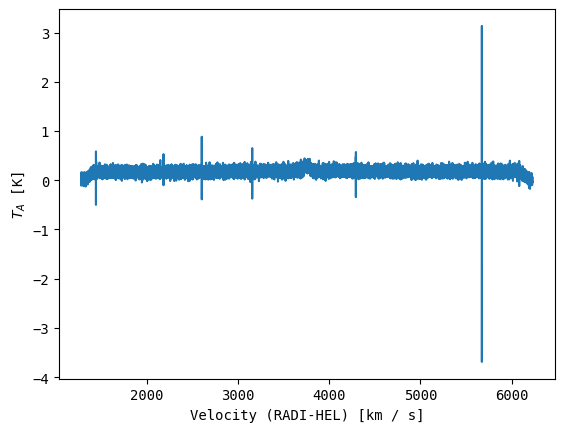

In [16]:
plt.figure()
plt.xlabel(f"Velocity ({s4.meta['VELDEF']}) [{s4.spectral_axis.unit}]")
plt.ylabel(f"$T_A$ [{s4.flux.unit}]")
plt.plot(s4.spectral_axis, s4.flux)

## Writing Multiple Calibrated Spectra to SDFITS
You can write the calibrated data from a `ScanBlock` to the SDFITS format.
If there are multiple scans in the `ScanBlock`, they will all be written to the same SDFITS (useful for `gbtgridder`).

In [17]:
ps_scan_block.write(output_dir / "scanblock.fits", overwrite=True)

## Reading Calibrated SDFITS

To load the saved data, we use the same function we used to load the raw data, `GBTFITSLoad`.

In [18]:
ps_scan_block_read = GBTFITSLoad(output_dir / "scanblock.fits")

This is treated the same was as the raw data, so the same methods are available.

In [19]:
ps_scan_block_read.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,11,1,198.343112,18.64274


However, since the data is already calibrated, trying to fetch the data using calibration methods like `getps` or `getnod` will result in errors.
Instead, we can use the `gettp` method or `getspec`.

### Using `gettp`

If we use `gettp`, then we will get all of the integrations as a `ScanBlock` object.

In [20]:
tp_read = ps_scan_block_read.gettp(scan=51, ifnum=0, plnum=0, fdnum=0)
print(f"Number of integrations: {tp_read[0].nint}")

Number of integrations: 11


We can access individual integration through the `calibrated` method.

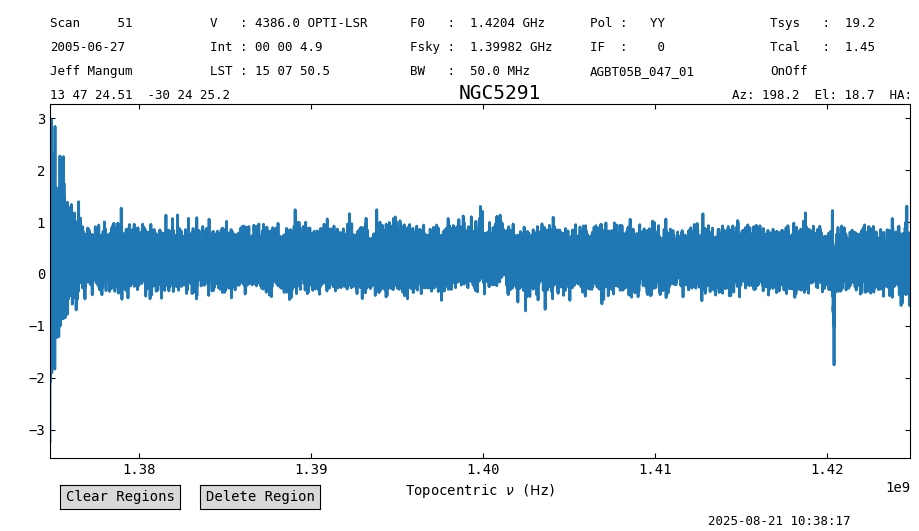

In [21]:
ta_read_0a = tp_read[0].getspec(0)
ta_read_0a.plot()

### Using `getspec`

Now we do the same using `getspec`. This method takes as input the row number we want to retrieve.

In [22]:
ta_read_0b = ps_scan_block_read.getspec(0)

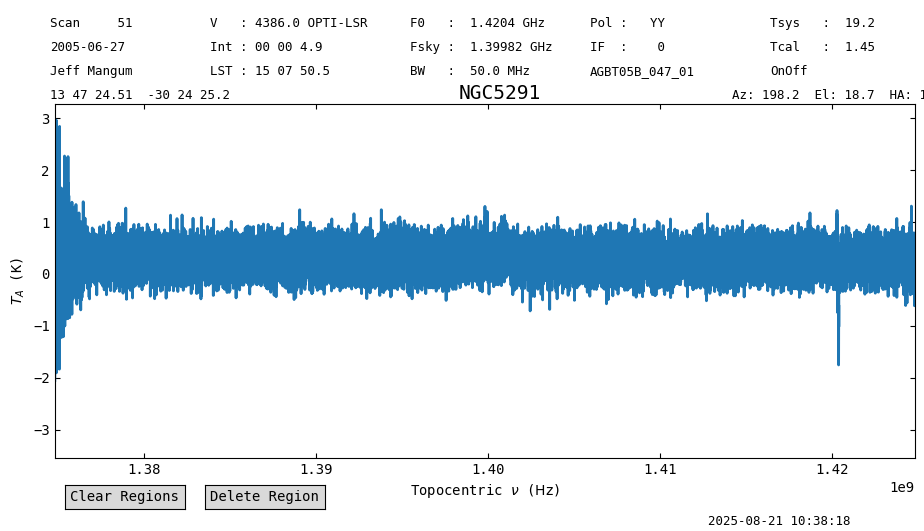

In [23]:
ta_read_0b.plot()

If we take the difference, it is zero.

In [24]:
(ta_read_0a.data - ta_read_0b.data).sum()

0.0

## Writing Out Selected Data from `GBTFITSLoad`
The `write()` method of `GBTFITSLoad` supports down-selection of data. 
Data can be selected on any SDFITS column.

In the following call to `GBTFITSLoad.write` we will select a single polarization (`plnum=1`), and only the first five integrations of each scan (`intnum=range(5)`). We also set `overwrite=True` to avoid errors if the file already exists, and request that the output be saved into a single file (`multifile=False`).

In [25]:
sdfits.write(output_dir / "mydata.fits", plnum=1, 
             intnum=range(5), overwrite=True, multifile=False)

 ID    TAG    PLNUM   INTNUM   # SELECTED
--- --------- ----- ---------- ----------
  0 72b00f1e4     1 range(0,5)         80


These data, can of course, be read back in.

In [26]:
sdfits2 = GBTFITSLoad(output_dir / "mydata.fits")

In [27]:
sdfits2.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,198.232659,18.673869
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,198.819965,18.819273
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,199.220655,18.388859
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,199.805833,18.526395
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,200.195158,18.091889
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,200.781482,18.221270
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,202.220144,17.422823
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,202.811698,17.533376


### Writing SDFITS to Multiple Files 
If the data came from multiple files, for instance VEGAS banks, then by default they are written to multiple files, so
`sdfits.write('mydata.fits')`
would write to mydata0.fits, mydata1.fits, ... mydataN.fits.
